In [1]:
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes
import numpy as np
import xarray as xr
from os.path import join
import reader
import pandas as pd

## Read the data

In [2]:
fname = "/data/jol/sat_data/sar_polar/cvms/CovMat.mat"
ds = reader.read_covar_matrix(fname)
# Write to MATLAB files
# for cm in ds.keys():
#    sio.savemat(f'data/CovMat_{cm}.mat', {'CovMat': ds[k].values})

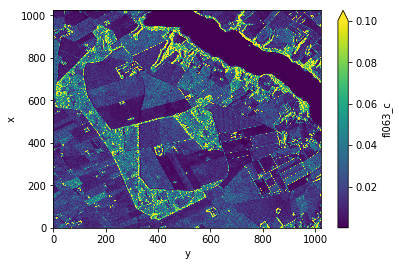

In [3]:
np.flip(np.abs(ds['fl063_c'].isel(i=1, j=1)), axis=0).plot(vmax=.1);

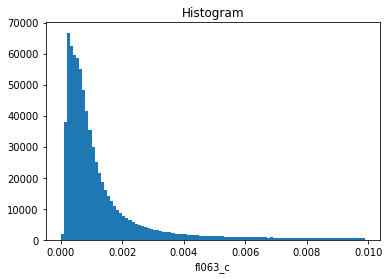

In [4]:
np.abs(ds['fl063_c'].isel(i=1, j=1)).plot.hist(bins=np.arange(0,0.01,0.0001));

## Plot the field mask

The mask labels are as follows:

1	Rye <br>
2	Grass (Rajgræs)<br>
3	Winter wheat<br>
4	Grass (Rajgræs)<br>
5	Winter wheat<br>
6	Spring barley<br>
7	Peas<br>
8	Rye<br>
9	Spring oats<br>
10	Grass (Rajgræs)<br>
11	Winter wheat<br>
12	Rye<br>
13	Spring barley<br>
14	Spring barley<br>
15	Peas<br>
16	Grass (Rajgræs)<br>
17	Winter barley<br>
18	Peas<br>
19	Peas<br>
20	Winter wheat<br>
21	Peas<br>
22	Winter wheat<br>
23	Rye<br>
24	Peas<br>
25	Winter barley<br>
26	Grass (Rajgræs)<br>
27	Winter wheat<br>
28	Peas<br>
29	Spring barley<br>
30	Beets<br>
31	Spring barley<br>
32	Grass (slet græs)<br>
33	Winter wheat<br>
34	Spring barley<br>
35	Winter wheat<br>
36	Spring barley<br>
37	Peas<br>

101 Lake<br>

There are only mask for the first 7 so far. 

In [6]:
mask = xr.open_rasterio('data/foulum_field_mask.tif').squeeze()
mask = xr.DataArray(mask.values, dims=('x', 'y'))
import scipy.io as sio
sio.savemat('data/foulum_field_mask.mat', {'fields': mask.values})

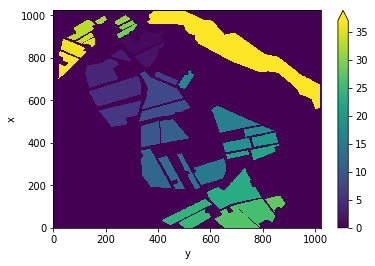

In [7]:
np.flip(mask, axis=0).plot(vmax=37);

## Make RGB plots

fl063_c


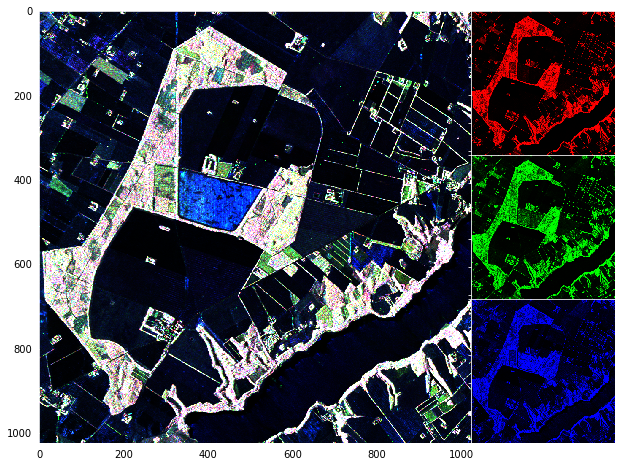

fl063_l


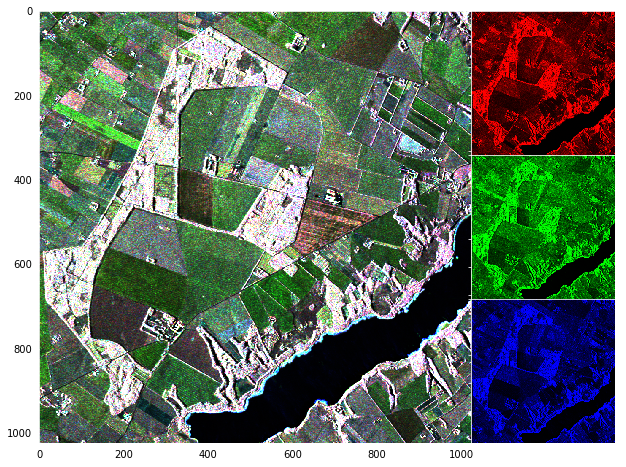

fl064_c


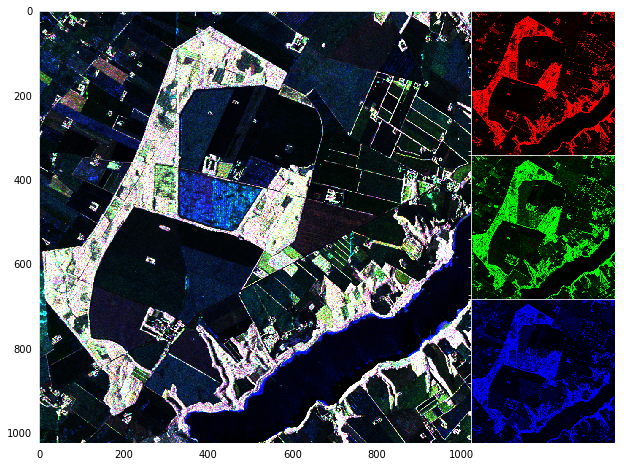

fl064_l


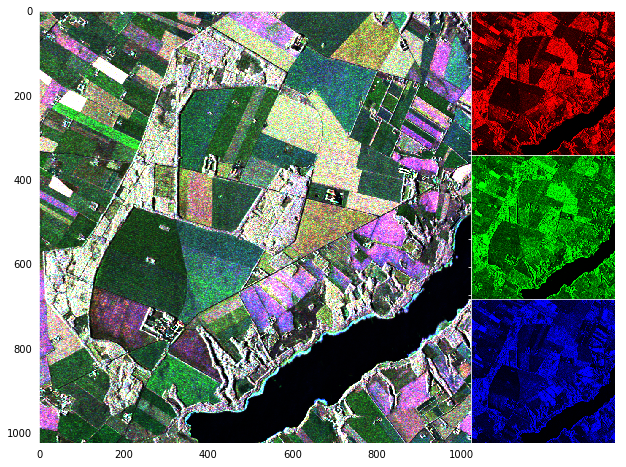

fl065_c


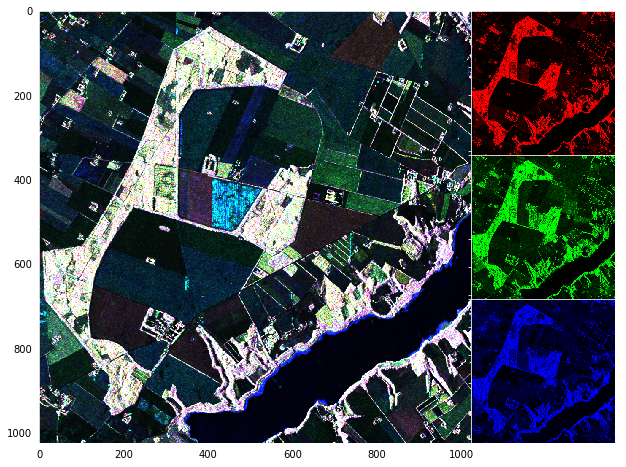

fl065_l


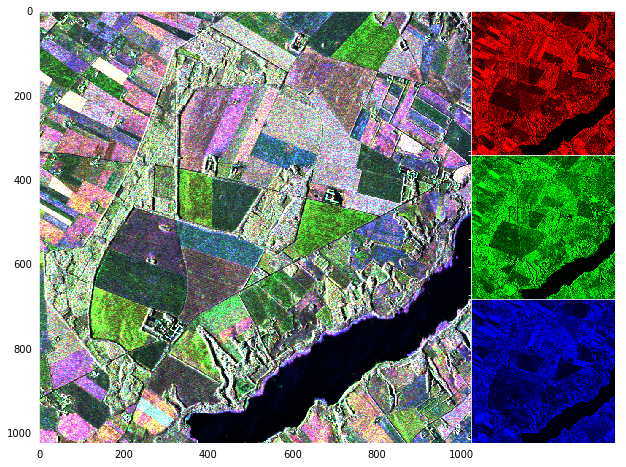

fl068_c


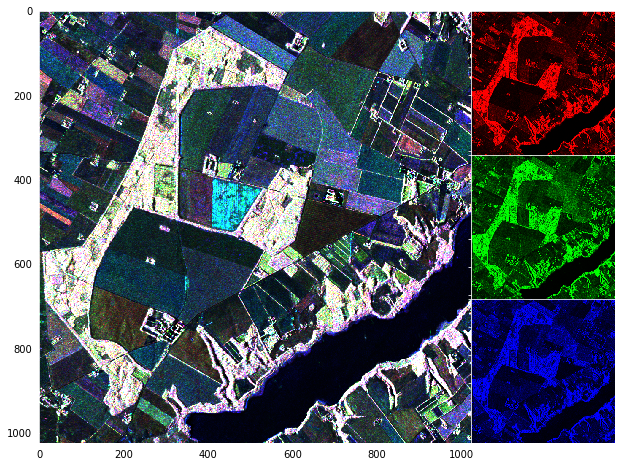

In [9]:
def normalise(r, g, b,, q=0.90):
    r = np.flip(r.real, axis=0)
    g = np.flip(g.real, axis=0)
    b = np.flip(b.real, axis=0)
    rgb = np.concatenate((r,g,h))
    rgb = np.clip(rgb / np.quantile(rgb, q))
    r, g, b = rgb.reshape(len(r), 3)
    return r, g, b

for v in list(ds.variables):
    da = ds[v]
    #r = normalise(da.isel(i=1,j=1))
    #g = normalise(da.isel(i=0,j=0))
    #b = normalise(da.isel(i=2,j=2))
    
    
    fig = plt.figure(figsize=(10, 10))
    #fig.text(0.5,0,v)
    ax = RGBAxes(fig, [0.1, 0.1, 0.8, 0.8])
    print(v)
    ax.imshow_rgb(r, g, b, vmax=.01)
    plt.show()
    #fname = join('/data/jol/sat_data/sar_polar/plots', v + '.png')
    #fig.savefig(fname, tightlayout=True)

## Caculate the ENLs

$\text{ENL} = \frac{E^2}{\sigma^2}$


In [8]:
diag_els = [(0, 0), (1, 1)]
all_els =[(i, j) for i in range(3) for j in range(3)]
def ENLs(field, k):
    for i, j in diag_els:
        ss = np.abs(ds[k].where(mask==field).sel(i=i, j=j))
        #np.abs(np.flip(ss, axis=0)).plot(vmax=10)
        #plt.title(f"m = {i}, p = {j}")
        #plt.show()
        #amp = 10**(10*np.abs(ss))
        E = ss.mean()
        Var = np.abs(ss).std(skipna=True)**2
        yield k, field, f"{i}{j}", float(E**2/Var)

def get_enls():
    for cov_matrix in ds.variables.keys():
        for field in range(1, 36):
            yield from ENLs(field, cov_matrix)

In [9]:
import warnings
warnings.simplefilter("ignore") 
enl_df = pd.DataFrame(list(get_enls()), columns=['cvm', 'field', 'ij', 'enls'])
enl_df = enl_df.sort_values(by=['cvm', 'field'])

In [14]:
cvms = sorted(list(enl_df.cvm.unique()), key=lambda x: x[-1])
for cvm in cvms:
    print(cvm)
    enls_cvm = enl_df[enl_df.cvm==cvm].pivot_table(index='field', columns='ij')
    enls_cvm['max'] = enls_cvm.apply(np.max, axis=1)
    enls_cvm.sort_values('max', inplace=True, ascending=False)
    print(enls_cvm.head())
    print('\n')

fl063_c
            enls                   max
ij            00         11           
field                                 
32     14.574822  11.862562  14.574822
7      13.812846  11.879868  13.812846
17     13.118739  11.216072  13.118739
26     13.105780  12.150774  13.105780
10     12.744379  12.562797  12.744379


fl064_c
            enls                   max
ij            00         11           
field                                 
29     14.591362  11.638428  14.591362
6      13.657099  13.167195  13.657099
18     13.336574  12.265437  13.336574
21     13.266271  11.573268  13.266271
15     11.870218  12.996864  12.996864


fl065_c
            enls                   max
ij            00         11           
field                                 
15     14.012592  13.139046  14.012592
19     12.439478  13.788994  13.788994
21     13.676818  13.515379  13.676818
13     13.617224  12.258194  13.617224
24     13.615926  12.242940  13.615926


fl068_c
            enls          

## Averaged array

In [170]:
ds_ave = ds.rolling(x=10,min_periods=1).mean().rolling(y=10,min_periods=1).mean()

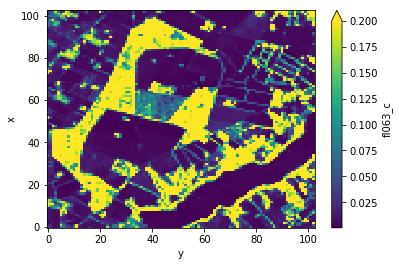

In [171]:
#np.flip(np.abs(ds_ave), axis=0).plot(vmax=0.2)
ds_ave2 = ds_ave.isel(x=slice(None,None,10), y=slice(None,None,10))
np.abs(ds_ave2['fl063_c'].sel(i=0, j=0)).plot(vmax=0.2)

## Q

In [169]:
X1s = np.ones((3, 3, 1024, 1024))
X1s[0,2] = X1s[1,2] = X1s[1,2] = X1s[2,0] = X1s[2,1] = 0
X = ds_ave.copy()*X1s

NameError: name 'ds_ave' is not defined

In [73]:
n, m = 3, 3
Q = X['fl063_c']**n * X['fl064_c']**m / (X['fl063_c'] + X['fl064_c'])**(m + n)

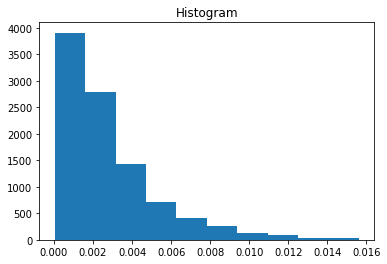

In [75]:
np.abs(Q.sel(i=0, j=0).where(mask==1)).plot.hist();

In [164]:
ds.groupby_bins('x', bins=np.arange(0,1024,2**3))

## Toolbox for SAR

https://www.orfeo-toolbox.org/CookBook/index_TOC.html